In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers torch datasets scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 8.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install xgboost

In [ ]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.8 MB/s eta 0:00:00


In [ ]:
!pip install imbalanced-learn

In [ ]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import pytz
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree, export_text
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Ensure you have the necessary NLTK data files
nltk.download('stopwords')
nltk.download('punkt')

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline

from collections import defaultdict
from collections import Counter
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from transformers import pipeline
from datasets import Dataset, DatasetDict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_fscore_support
np.random.seed(0)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Load Datasets

In [ ]:
# load pickle file of the dataset with sentiment analysis added
df_filtered = pd.read_pickle('/content/drive/My Drive/twitter/twitter_sentiment.pkl')

In [ ]:
# load pickle file of game_log_df
game_log_df = pd.read_pickle('/content/drive/My Drive/twitter/game_log_df.pkl')

In [ ]:
print(game_log_df)

   team_action        action game_time  quarter  patriots_score  \
0     patriots          punt     11:44      1.0             0.0   
1     seahawks          punt     09:30      1.0             0.0   
2     patriots  interception     01:50      1.0             0.0   
3     seahawks          punt     14:08      2.0             0.0   
4     patriots     touchdown     09:47      2.0             7.0   
5     seahawks          punt     08:17      2.0             7.0   
6     patriots          punt     07:17      2.0             7.0   
7     seahawks     touchdown     02:16      2.0             7.0   
8     patriots     touchdown     00:31      2.0            14.0   
9     seahawks     touchdown     00:02      2.0            14.0   
10    seahawks    field_goal     11:09      3.0            14.0   
11    patriots  interception     08:15      3.0            14.0   
12    seahawks     touchdown     04:54      3.0            14.0   
13    patriots          punt     03:24      3.0            14.

In [ ]:
def scale_times_to_hour(df, target_hour=19):
    # Read the last datetime object in the 'real_time' column
    last_datetime = df['real_time'].iloc[-1]

    # Extract the hour from the last datetime object
    last_hour = last_datetime.hour

    # Calculate the difference in hours to shift
    hour_diff = target_hour - last_hour

    # Define a function to shift the datetime by the hour difference
    def shift_time(dt, hours):
        return dt + pd.Timedelta(hours=hours)

    # Apply the shift to the 'real_time' column
    df['real_time'] = df['real_time'].apply(shift_time, hours=hour_diff)


    # Convert 'real_time' to datetime (assumed to be in UTC)
    df['real_time'] = pd.to_datetime(df['real_time'])

    return df

In [ ]:
game_log_df = scale_times_to_hour(game_log_df)

In [ ]:
print(game_log_df)

   team_action        action game_time  quarter  patriots_score  \
0     patriots          punt     11:44      1.0             0.0   
1     seahawks          punt     09:30      1.0             0.0   
2     patriots  interception     01:50      1.0             0.0   
3     seahawks          punt     14:08      2.0             0.0   
4     patriots     touchdown     09:47      2.0             7.0   
5     seahawks          punt     08:17      2.0             7.0   
6     patriots          punt     07:17      2.0             7.0   
7     seahawks     touchdown     02:16      2.0             7.0   
8     patriots     touchdown     00:31      2.0            14.0   
9     seahawks     touchdown     00:02      2.0            14.0   
10    seahawks    field_goal     11:09      3.0            14.0   
11    patriots  interception     08:15      3.0            14.0   
12    seahawks     touchdown     04:54      3.0            14.0   
13    patriots          punt     03:24      3.0            14.

# Combine the tweet dataset with the game activity dataset

In [ ]:
# Sort the DataFrames
df_filtered = df_filtered.sort_values('time_posted', ascending=True)
game_log_df = game_log_df.sort_values('real_time', ascending=True)

# Convert 'real_time' in game_log_df to datetime with US/Pacific timezone
game_log_df['real_time'] = pd.to_datetime(game_log_df['real_time']).dt.tz_localize('US/Pacific')

# Merge the DataFrames on the closest previous time in game_scores_df for each tweet time
merged_df = pd.merge_asof(df_filtered.sort_values('time_posted'), game_log_df.sort_values('real_time'), left_on='time_posted', right_on='real_time', direction='backward')

# Identify the first and last events in the game log DataFrame
first_event = game_log_df.iloc[0]
last_event = game_log_df.iloc[-1]

# Identify the tweets posted before the start time of the game and after the end time of the game
tweets_before_game_start = df_filtered[df_filtered['time_posted'] < game_log_df['real_time'].min()]
tweets_after_game_end = df_filtered[df_filtered['time_posted'] > game_log_df['real_time'].max()]

# Paste the first event backward to the tweets that precede the start time of the game
if not tweets_before_game_start.empty:
    tweets_before_game_start = tweets_before_game_start.assign(**first_event)

# Paste the last event forward to the tweets that are posted after the end time of the game
if not tweets_after_game_end.empty:
    tweets_after_game_end = tweets_after_game_end.assign(**last_event)

# Concatenate the modified DataFrames
final_df = pd.concat([tweets_before_game_start, merged_df, tweets_after_game_end], ignore_index=True)

In [ ]:
print(final_df.head())

                time_posted  retweets  followers    author_name     hashtag  \
0 2015-02-01 15:00:00-08:00         2     7664.0  Dennis Bounds     gohawks   
1 2015-02-01 15:00:00-08:00         1       37.0    mrs.Jozelia  gopatriots   
2 2015-02-01 15:00:00-08:00         1       53.0    Heidi Inman     gohawks   
3 2015-02-01 15:00:00-08:00         2       45.0    Gwenie Rose     gohawks   
4 2015-02-01 15:00:00-08:00         1      381.0     Sean Mason     gohawks   

                                                text  \
0  Touchdown in Seattle. Now for #seahawks TDs in...   
1  Hoje nÃ£o tem pra ninguÃ©m e patriots #GoPatri...   
2        #GoHawks that is all http://t.co/fV7t5QPXys   
3  Ready to party...#GoHawks #SB49 #Seahawks http...   
4                             30 minutes!!! #GoHawks   

                                        cleaned_text  \
0    touchdown seattle seahawks tds see game gohawks   
1  hoje tem pra ningum e patriots gopatriots gopa...   
2                   

In [ ]:
print(final_df.shape)

(221356, 19)


In [ ]:
print(final_df.tail())

                     time_posted  retweets  followers         author_name  \
221351 2015-02-01 19:59:50-08:00         1      149.0       Norman Norman   
221352 2015-02-01 19:59:55-08:00         1       60.0        Pete Naiukow   
221353 2015-02-01 19:59:57-08:00         4     1664.0  FoxboroughFire2252   
221354 2015-02-01 19:59:57-08:00         1      443.0          Lisa Mezik   
221355 2015-02-01 19:59:59-08:00         1     1423.0       cheryl daniel   

         hashtag                                               text  \
221351  patriots  Congrats to Tom Brady for breaking a post-seas...   
221352  patriots  #superbowlcommercials \n#PatriotsWIN #Patriots...   
221353  patriots  @Patriots Congratulations to our hometown New ...   
221354  patriots  The #Patriots Win 28-24!!!! #Superbowl49 http:...   
221355   gohawks  @eigenseide @DaynaOG @bcondotta Hope #Seahawks...   

                                             cleaned_text  \
221351  congrats tom brady breaking postseason re

# Create dynamic labels for game score to determine the winning team across time

In [ ]:
# Assign dynamic labels for the winning team for labels
def determine_winning_team(row):
    if row['patriots_score'] > row['seahawks_score']:
        return 2
    elif row['patriots_score'] < row['seahawks_score']:
        return 1
    else:
        return 0

# patriots winning = 2
# seahawks winning = 1
# tie score = 0

In [ ]:
# Apply the function to each row to create a 'winning_team' column
final_df['winning_team'] = final_df.apply(determine_winning_team, axis=1)

#create labels as y
y = final_df['winning_team']

# Choose features for model training

In [ ]:
final_df['sentiment_positive'] = final_df['sentiment_positive'].astype(float)
final_df['sentiment_negative'] = final_df['sentiment_negative'].astype(float)
final_df['retweets'] = final_df['retweets'].astype(int)

In [ ]:
# Feature selection
features = ['sentiment_positive', 'sentiment_negative', 'retweets', 'hashtag', 'lemmatized_text', 'action', 'team_action']
X = final_df[features]

In [ ]:
# get the hashtag counts from final_df
hashtag_counts = final_df['hashtag'].value_counts()
print(hashtag_counts)

hashtag
patriots      156704
gohawks        48208
gopatriots     16444
Name: count, dtype: int64


# Balance the dataset

In [ ]:
# Function to balance the dataset by seahawks and patriots fans
def balance_dataset(df, label_column='hashtag', random_state=0):
    # Get counts of each label
    label_counts = df[label_column].value_counts()

    # Find the minimum count among the labels
    min_count = label_counts.min()

    # Sample equal number of samples for each label
    balanced_df = pd.concat([
        df[df[label_column] == label].sample(min_count, random_state=random_state)
        for label in label_counts.index
    ])

    # Shuffle the balanced DataFrame
    balanced_df = balanced_df.sample(frac=1, random_state=random_state)

    return balanced_df

In [ ]:
# Create a balanced dataset with equal numbers of seahawks and patriots fans
balanced_df = balance_dataset(final_df)

In [ ]:
# split the dataframe into X and y values
balanced_X = balanced_df[features]
balanced_y = balanced_df['winning_team']

In [ ]:
# Check size of balanced dataset
print(balanced_X.shape)
print(balanced_y.shape)

(49332, 7)
(49332,)


# Split data into train and test sets

In [ ]:
# split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y, test_size=0.2, random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(39465, 7)
(9867, 7)
(39465,)
(9867,)


# Create pipeline for preprocessing and model training

In [ ]:
# Function to preprocess the data and train the model
def train_and_evaluate_model(X_train, X_test, y_train, y_test, classifier):
    # Define transformers for different types of features
    transformers = [
        ('sentiment', 'passthrough', ['sentiment_positive', 'sentiment_negative']),
        ('retweets', 'passthrough', ['retweets']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['hashtag', 'action', 'team_action']),
        ('text', TfidfVectorizer(), 'lemmatized_text')
    ]

    # Create column transformer
    preprocessor = ColumnTransformer(transformers, remainder='drop')

    # Create a pipeline with preprocessor and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = pipeline.predict(X_test)

    # Define class names
    class_names = ['tie score', 'seahawks winning', 'patriots winning']
    # Print the classification report
    print(classification_report(y_test, y_pred, target_names=class_names))
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return pipeline

# Apply dimensionality reduction

                  precision    recall  f1-score   support

       tie score       0.95      0.96      0.95      6242
seahawks winning       0.88      0.89      0.88      2226
patriots winning       0.95      0.89      0.92      1399

        accuracy                           0.93      9867
       macro avg       0.93      0.91      0.92      9867
    weighted avg       0.93      0.93      0.93      9867



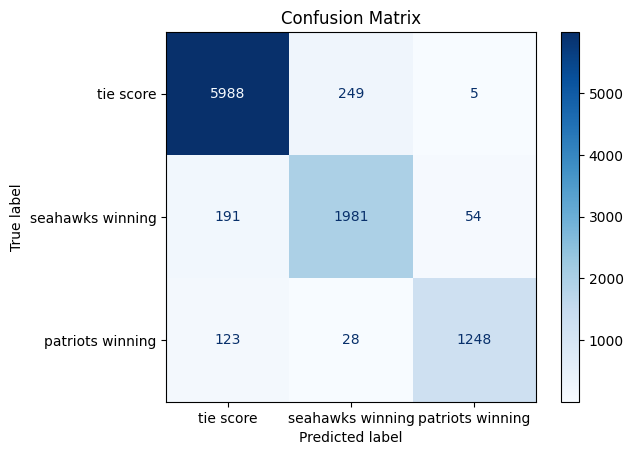

In [ ]:
# train a balanced Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
pipeline = train_and_evaluate_model(X_train, X_test, y_train, y_test, rf_classifier)

In [ ]:
# Access the Random Forest classifier from the pipeline
rf_classifier = pipeline.named_steps['classifier']

# Get feature importances
feature_importances = rf_classifier.feature_importances_

print(feature_importances)
print(feature_importances.size)

[1.89615549e-02 1.78620413e-02 4.75177638e-03 ... 9.61955948e-08
 8.68325642e-10 3.85561990e-06]
20838


Even with such a limited text field, the dimensinality of the feature set is very high with the sparse tweet text representations.  Lets try dimensionality reduction in the text field to reduce the number of features.

As chosen in the other notebook, the optimal number of components will be set to 50.

In [ ]:
# Function to preprocess the data and train the model
def train_and_evaluate_model_dimreduce(X_train, X_test, y_train, y_test, classifier):
    # Define transformers for different types of features
    transformers = [
        ('sentiment', 'passthrough', ['sentiment_positive', 'sentiment_negative']),
        ('retweets', 'passthrough', ['retweets']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['hashtag', 'action', 'team_action']),
        ('text', Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('lsi', TruncatedSVD(n_components=50))
        ]), 'lemmatized_text')
    ]

    # Create column transformer
    preprocessor = ColumnTransformer(transformers, remainder='drop')

    # Create a pipeline with preprocessor and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = pipeline.predict(X_test)

    # Define class names
    class_names = ['tie score', 'seahawks winning', 'patriots winning']
    # Print the classification report
    print(classification_report(y_test, y_pred, target_names=class_names))
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return pipeline

# Time to up the game with a DL pretrained model

In [ ]:
# Function to tokenize the data
def tokenize_data(tokenizer, texts, labels, max_length=128):
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    inputs['labels'] = torch.tensor(labels)
    return inputs

In [ ]:
# Function to return metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Function to train and evaluate a BERT pretrained model
def evaluate_model_with_transformer(X_train, y_train, X_test, y_test):
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    model.to(device)

    # Tokenize the text data
    train_inputs = tokenize_data(tokenizer, X_train['lemmatized_text'].tolist(), y_train.tolist())
    test_inputs = tokenize_data(tokenizer, X_test['lemmatized_text'].tolist(), y_test.tolist())

    # Convert to Hugging Face dataset
    train_dataset = Dataset.from_dict(train_inputs)
    test_dataset = Dataset.from_dict(test_inputs)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy='epoch'
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    results = trainer.evaluate()
    print(results)

    # Make predictions
    preds_output = trainer.predict(test_dataset)
    preds = preds_output.predictions.argmax(-1)

    # Print classification report
    class_names = ['tie score', 'seahawks winning', 'patriots winning']
    print(classification_report(y_test, preds, target_names=class_names))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, preds)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.713700,0.675656,0.715618,0.692861,0.693070,0.715618


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.713700,0.675656,0.715618,0.692861,0.693070,0.715618
2,0.601800,0.648598,0.734367,0.717405,0.715583,0.734367
3,0.505500,0.724518,0.740448,0.730735,0.726384,0.740448


{'eval_loss': 0.7245177030563354, 'eval_accuracy': 0.7404479578392622, 'eval_f1': 0.7307349118881322, 'eval_precision': 0.7263836852823581, 'eval_recall': 0.7404479578392622, 'eval_runtime': 31.6982, 'eval_samples_per_second': 311.28, 'eval_steps_per_second': 19.465, 'epoch': 3.0}
                  precision    recall  f1-score   support

       tie score       0.81      0.89      0.85      6242
seahawks winning       0.57      0.47      0.52      2226
patriots winning       0.59      0.51      0.55      1399

        accuracy                           0.74      9867
       macro avg       0.66      0.62      0.64      9867
    weighted avg       0.73      0.74      0.73      9867



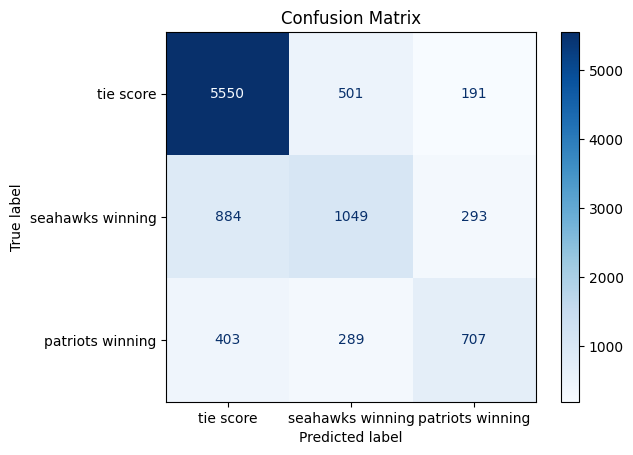

In [ ]:
# Train and evaluate the pretrained BERT model
evaluate_model_with_transformer(X_train, y_train, X_test, y_test)

Now, BERT is only training on the tweet text data, which is obviously not enough features to properly predict the winning team.  But running this model with only one feature set (tweet text) shows us the predictive power of that single data field.  Which is great, because now we know that tweet content is junk (we already knew that) and we need our other fields to carry the load.  Now, it would be interesting to combine BERT and Random Forest to get the most accuracy out of BERT for the tweet text while also using our other features.

# Fusion model to combine BERT and Random Forest

In [ ]:
def train_bert_model(X_train, y_train):
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    model.to(device)

    # Tokenize the text data
    train_inputs = tokenize_data(tokenizer, X_train['lemmatized_text'].tolist(), y_train.tolist())
    test_inputs = tokenize_data(tokenizer, X_test['lemmatized_text'].tolist(), y_test.tolist())

    # Convert to Hugging Face dataset
    train_dataset = Dataset.from_dict(train_inputs)
    test_dataset = Dataset.from_dict(test_inputs)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy='epoch'
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )

    # Train model
    trainer.train()

    return model, tokenizer

In [ ]:
# Function to preprocess other features and train RandomForestClassifier
def train_rf_model(X, y):
    # Define transformers for different types of features
    transformers = [
        ('sentiment', 'passthrough', ['sentiment_positive', 'sentiment_negative']),
        ('retweets', 'passthrough', ['retweets']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['hashtag', 'action', 'team_action'])
    ]

    # Create column transformer
    preprocessor = ColumnTransformer(transformers, remainder='drop')

    # Define the pipeline with preprocessor and classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=0))
    ])

    # Train the model
    pipeline.fit(X, y)

    return pipeline

In [ ]:
# Function to combine BERT and RandomForest predictions
def combine_predictions(bert_model, bert_tokenizer, rf_pipeline, X_test_text, X_test_features, y_test):
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Tokenize text data
    inputs = tokenize_data(bert_tokenizer, X_test_text.tolist(), y_test.tolist())
    dataset = Dataset.from_dict(inputs)

    # Move the dataset to the same device as the BERT model
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    dataset = dataset.map(lambda batch: {k: v.to(device) for k, v in batch.items()})

    # Ensure BERT model is on the same device
    bert_model.to(device)

    # Perform forward pass inference on BERT model
    bert_outputs = []
    for batch in torch.utils.data.DataLoader(dataset, batch_size=16):
        with torch.no_grad():
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            outputs = bert_model(**inputs)
            logits = outputs.logits

        bert_outputs.append(logits.cpu()) #move preds to CPU

    # Combine and process BERT outputs
    bert_predictions = torch.cat(bert_outputs, dim=0)
    y_pred_bert = bert_predictions.argmax(dim=1).cpu().numpy()

    # Predict and evaluate RandomForestClassifier on other features
    y_pred_rf = rf_pipeline.predict(X_test_features)

    # Combine predictions (simple majority voting)
    y_pred_combined = np.round((y_pred_bert + y_pred_rf) / 2)

    # Print classification report
    print(classification_report(y_test, y_pred_combined, target_names=['tie score', 'seahawks winning', 'patriots winning']))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_combined)
    # Define class names
    class_names = ['tie score', 'seahawks winning', 'patriots winning']
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# Function to extract Bert representations from the tweet text data
def extract_bert_representations(text_data, batch_size=32):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # Load pre-trained BERT model and tokenizer
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)

    bert_model.eval()  # Set model to evaluation mode

    all_representations = []

    # Process text data in batches
    for i in range(0, len(text_data), batch_size):
        batch_texts = text_data[i:i + batch_size]
        # Tokenize the text data
        inputs = bert_tokenizer(batch_texts.tolist(), padding=True, truncation=True, return_tensors='pt')
        # Move inputs to the same device as the model
        inputs = {key: value.to(device) for key, value in inputs.items()}

        with torch.no_grad():
            outputs = bert_model(**inputs)

        # Extract logits and move them to CPU
        batch_representations = outputs.logits.cpu().numpy()
        all_representations.append(batch_representations)

    # Concatenate all batch representations
    representations = np.concatenate(all_representations, axis=0)

    return representations

In [ ]:
# Extract BERT representations for training data
X_train_bert_representations = extract_bert_representations(X_train['lemmatized_text'])
X_test_bert_representations = extract_bert_representations(X_test['lemmatized_text'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define transformers for different types of features
transformers = [
    ('sentiment', 'passthrough', ['sentiment_positive', 'sentiment_negative']),
    ('retweets', 'passthrough', ['retweets']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['hashtag', 'action', 'team_action'])
]

# Create column transformer
preprocessor = ColumnTransformer(transformers, remainder='drop')

# Fit and transform the non-text data
X_train_non_text = preprocessor.fit_transform(X_train)
X_test_non_text = preprocessor.transform(X_test)

In [ ]:
# Combine BERT representations with other features
X_train_combined = np.hstack((X_train_non_text, X_train_bert_representations))
X_test_combined = np.hstack((X_test_non_text, X_test_bert_representations))

In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=17)
X_train_combined_pca = pca.fit_transform(X_train_combined)
X_test_combined_pca = pca.transform(X_test_combined)

In [ ]:
# Define and train the model
classifier = RandomForestClassifier(n_estimators=100, random_state=0)
classifier.fit(X_train_combined_pca, y_train)

                  precision    recall  f1-score   support

       tie score       0.90      0.94      0.92      6242
seahawks winning       0.80      0.78      0.79      2226
patriots winning       0.96      0.83      0.89      1399

        accuracy                           0.89      9867
       macro avg       0.89      0.85      0.87      9867
    weighted avg       0.89      0.89      0.89      9867



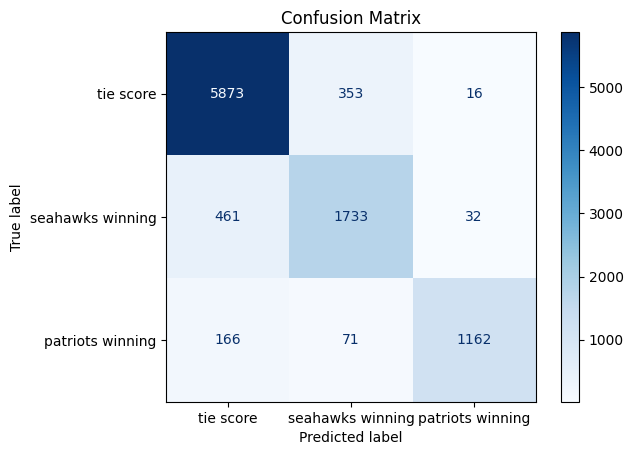

In [ ]:
# Predict and evaluate
y_pred = classifier.predict(X_test_combined_pca)
print(classification_report(y_test, y_pred, target_names=['tie score', 'seahawks winning', 'patriots winning']))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = ['tie score', 'seahawks winning', 'patriots winning']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Well, I guess I'm a little shocked that a BERT pretrained model combined with Random Forest didn't outperform the original Random Forest model.  Apparently all these features must be grouped and trained together for best results.  I suppose I'll refine the best performing model (LightGBM) for best results.

# Can we use a generative model to create a tweet based on the game score?

In [1]:
from transformers import pipeline

In [2]:
# Load gpt2 pre-trained generative model
generator = pipeline('text-generation', model='gpt2')

def generate_synthetic_tweet(score_change):
    prompt = f"The current score is: {score_change}. Update tweet: "
    generated_tweet = generator(prompt, max_length=50, truncation='longest_first', num_return_sequences=2)
    return generated_tweet[0]['generated_text']

# Use the function to generate a synthetic tweet
score_change = "Patriots 14 - Seahawks 10"
tweet = generate_synthetic_tweet(score_change)
print(tweet)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The current score is: Patriots 14 - Seahawks 10. Update tweet:  "NFL is not worried about their safety. We have a number of issues, and this game goes down as an aberration." pic.twitter.com/zS


Ok, this model is neat.  I like it!